# Import Libraries

In [ ]:
import os

import torchvision
from torchvision import transforms, datasets, models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

# Device Configs

In [ ]:
# Set device type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set the path where the data is stored
DATASET_PATH = '/content/gdrive/MyDrive/GarbageClassification'
# Set the path where the trained model will be stored
MODEL_PATH = '/content/gdrive/MyDrive/models/final_model.pth'

# Data preparation

## Get Dataset

In [ ]:
# Set the input size to match the input layer of the model
input_h = 224
input_w = 224

In [ ]:
# Functions for data agumentation
data_transforms = {
    'original': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
    ]),
    'train': transforms.Compose([
        transforms.RandomResizedCrop((input_h, input_w), scale=(0.5, 1)),
        transforms.RandomHorizontalFlip(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((input_h, input_w))
    ])
}

In [ ]:
# Function to re-Argument data from already created datasets.
class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        img, label = self.dataset[index]
        return self.transform(img), label
    
    def __len__(self):
        return len(self.dataset)

In [ ]:
# Get pure dataset with simple normalization
orig_dataset = torchvision.datasets.ImageFolder(DATASET_PATH, transform=data_transforms['original'])

# NUMBER OF TOTAL DATA: 15515
# NUMBER OF CLASSES: 12
# CLASSES: {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}
paper


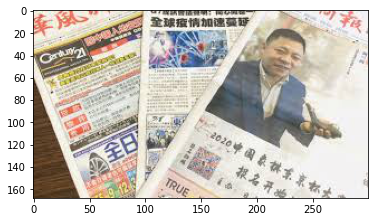

In [ ]:
# Check Dataset
num_total_data = len(orig_dataset)
print(f'# NUMBER OF TOTAL DATA: {num_total_data}')

num_classes = len(orig_dataset.classes)
print(f'# NUMBER OF CLASSES: {num_classes}')

idx_to_class = {value: key for key, value in orig_dataset.class_to_idx.items()}
print(f'# CLASSES: {idx_to_class}')

# Check Data and Label
rand_idx = int(torch.randint(0, num_total_data, (1, 1)))

unnormalize = transforms.Compose([
    transforms.Normalize((0, 0, 0), (1/0.229, 1/0.224, 1/0.225)),
    transforms.Normalize((-0.485, -0.456, -0.406), (1, 1, 1))
])

print(idx_to_class[orig_dataset[rand_idx][1]])
plt.imshow(transforms.functional.to_pil_image(unnormalize(orig_dataset[rand_idx][0])))

## Split Dataset

In [ ]:
# Set pre-defined proportions for TRAIN / DEV / TEST DATASET
train_rate = 0.8
dev_rate = 0.1
test_rate = 0.1

In [ ]:
# Function that split data by pre-defined proportions
def data_split(orig_dataset, train_rate, dev_rate, test_rate):
    if train_rate + dev_rate + test_rate != 1:
        raise ValueError
    
    orig_size = len(orig_dataset)
    
    test_size, dev_size = int(orig_size * test_rate), int(orig_size * dev_rate)
    train_size = int(orig_size - dev_size - test_size)
    
    train_dataset, dev_dataset, test_dataset = random_split(orig_dataset, [train_size, dev_size, test_size])
    
    train_dataset = TransformDataset(train_dataset, data_transforms['train'])
    dev_dataset = TransformDataset(dev_dataset, data_transforms['test'])
    test_dataset = TransformDataset(test_dataset, data_transforms['test'])
    
    return train_dataset, dev_dataset, test_dataset

In [ ]:
# Get TRAIN / DEV / TEST DATASET
train_dataset, dev_dataset, test_dataset = data_split(orig_dataset, train_rate, dev_rate, test_rate)

In [ ]:
# Check Dataset
num_train_data, num_dev_data, num_test_data = len(train_dataset), len(dev_dataset), len(test_dataset)
print(f'# NUMBER OF TRAIN DATA: {num_train_data}')
print(f'# NUMBER OF DEV   DATA: {num_dev_data}')
print(f'# NUMBER OF TEST  DATA: {num_test_data}')

# NUMBER OF TRAIN DATA: 12413
# NUMBER OF DEV   DATA: 1551
# NUMBER OF TEST  DATA: 1551


## Get Dataloader

In [ ]:
# Set batch size
batch_size = 32

# Get DATALOADER
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# Model

In [ ]:
# MODEL
class CustomModel(nn.Module):
    def __init__(self, num_classes, drop_prop):
        super(CustomModel, self).__init__()

        # early layer
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1      # ImageNet으로 학습된 모델 가중치 불러오기
        self.model = models.efficientnet_b0(weights=weights)

        # Classifier
        num_ftrs = self.model.classifier[1].in_features     # classifier 수정
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=drop_prop),
            nn.Linear(num_ftrs, num_classes)
        )
        
        for name, parameter in self.model.named_parameters():
            tmp = name.split('.')
            if('classifier' in tmp):
                parameter.requires_grad = True      # layer 중 classifier은 가중치 학습 O
            else:
                parameter.requires_grad = False     # early layer은 가중치 학습 X

    def forward(self, x):
        return self.model(x)

In [ ]:
def get_model(num_classes, drop_prop=0):
    model = CustomModel(num_classes, drop_prop)
    return model

In [ ]:
def get_optimizer(model, learning_rate, weight_decay=0):
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=0)
    return optimizer

# Train

In [ ]:
# Function for LambdaLR
def decay_func(epoch):
    if epoch < 20:
        return 0.5 ** 0
    elif epoch < 25:
        return 0.5 ** 1
    elif epoch < 30:
        return 0.5 ** 2
    else:
        return 0.5 ** 4

In [ ]:
def train(model, criterion, optimizer, dataloader):
    model.train()

    losses, accuracy = 0, 0
    for images, labels in tqdm(dataloader):
        images, labels  = images.to(device), labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        losses += loss.item()

        accuracy += (output.argmax(1) == labels).type(torch.float).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses, accuracy = losses / len(dataloader), (accuracy / len(dataloader.dataset)) * 100
    return losses, accuracy

In [ ]:
def evaluate(model, criterion, optimizer, dataloader):
    model.eval()

    losses, accuracy = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            loss = criterion(output, labels)
            losses += loss.item()

            accuracy += (output.argmax(1) == labels).type(torch.float).sum().item()

    losses, accuracy = losses / len(dataloader), (accuracy / len(dataloader.dataset)) * 100
    return losses, accuracy

In [ ]:
dropout = 0.3
learning_rate = 0.0004426
weight_decay =0.00001
epochs = 40

In [ ]:
def fit():    
    # History
    
    # Model
    model = get_model(num_classes, dropout).to(device)

    # Loss Function
    criterion = nn.CrossEntropyLoss()   # CrossEntropy

    # Optimizer 
    optimizer = get_optimizer(model, learning_rate, weight_decay)   # Adam, weight decay
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = decay_func)  # lr decay
    
    # History
    train_losses = []
    train_accuracies = []
    dev_losses = []
    dev_accuracies = []
    
    for epoch in range(epochs):
        # Train
        train_loss, train_accuracy = train(model, criterion, optimizer, train_dataloader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"# TRAIN     (EPOCH: {epoch + 1}/{epochs}) | LOSS: {train_loss:.4f} | ACCURACY: {train_accuracy:.4f}% ")

        # Dev
        dev_loss, dev_accuracy = evaluate(model, criterion, optimizer, dev_dataloader)
        dev_losses.append(dev_loss)
        dev_accuracies.append(dev_accuracy)
        print(f"# DEV (EPOCH: {epoch + 1}/{epochs}) | LOSS: {dev_loss:.4f} | ACCURACY: {dev_accuracy:.4f}% ")
        
        # Leaning Rate Decay를 위한 Scheduler 갱신
        scheduler.step()

    # Test
    test_loss, test_accuracy = evaluate(model, criterion, optimizer, test_dataloader)
    print(f"# SUMMARY")
    print(f"# FINAL TRAIN | LOSS: {train_loss:.4f} | ACCURACY: {train_accuracy:.4f}% ")
    print(f"# FINAL DEV   | LOSS: {dev_loss:.4f} | ACCURACY: {dev_accuracy:.4f}% ")
    print(f"# FINAL TEST  | LOSS: {test_loss:.4f} | ACCURACY: {test_accuracy:.4f}%")
    
    # 모델 저장
    torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'final_model.pth'))
    
    return train_losses, train_accuracies, dev_losses, dev_accuracies

In [ ]:
train_losses, train_accuracies, dev_losses, dev_accuracies = fit()

  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 1/40) | LOSS: 0.9486 | ACCURACY: 76.4360% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 1/40) | LOSS: 0.4629 | ACCURACY: 89.5551% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 2/40) | LOSS: 0.4600 | ACCURACY: 88.2704% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 2/40) | LOSS: 0.3228 | ACCURACY: 92.6499% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 3/40) | LOSS: 0.3773 | ACCURACY: 89.3740% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 3/40) | LOSS: 0.2647 | ACCURACY: 93.2302% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 4/40) | LOSS: 0.3322 | ACCURACY: 90.4374% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 4/40) | LOSS: 0.2425 | ACCURACY: 93.6815% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 5/40) | LOSS: 0.3051 | ACCURACY: 91.2914% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 5/40) | LOSS: 0.2279 | ACCURACY: 93.8104% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 6/40) | LOSS: 0.2944 | ACCURACY: 91.2189% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 6/40) | LOSS: 0.2131 | ACCURACY: 94.3262% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 7/40) | LOSS: 0.2815 | ACCURACY: 91.3397% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 7/40) | LOSS: 0.2099 | ACCURACY: 93.9394% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 8/40) | LOSS: 0.2769 | ACCURACY: 91.4283% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 8/40) | LOSS: 0.2001 | ACCURACY: 94.6486% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 9/40) | LOSS: 0.2654 | ACCURACY: 91.8070% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 9/40) | LOSS: 0.1966 | ACCURACY: 94.3262% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 10/40) | LOSS: 0.2562 | ACCURACY: 92.3870% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 10/40) | LOSS: 0.1882 | ACCURACY: 94.9065% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 11/40) | LOSS: 0.2592 | ACCURACY: 91.9600% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 11/40) | LOSS: 0.1956 | ACCURACY: 94.1973% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 12/40) | LOSS: 0.2458 | ACCURACY: 92.2823% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 12/40) | LOSS: 0.1847 | ACCURACY: 94.4552% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 13/40) | LOSS: 0.2460 | ACCURACY: 92.3709% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 13/40) | LOSS: 0.1804 | ACCURACY: 94.5197% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 14/40) | LOSS: 0.2373 | ACCURACY: 92.4917% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 14/40) | LOSS: 0.1803 | ACCURACY: 94.4552% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 15/40) | LOSS: 0.2344 | ACCURACY: 92.6770% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 15/40) | LOSS: 0.1802 | ACCURACY: 94.9710% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 16/40) | LOSS: 0.2313 | ACCURACY: 92.4998% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 16/40) | LOSS: 0.1767 | ACCURACY: 95.3578% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 17/40) | LOSS: 0.2221 | ACCURACY: 92.8220% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 17/40) | LOSS: 0.1736 | ACCURACY: 95.0999% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 18/40) | LOSS: 0.2337 | ACCURACY: 92.6690% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 18/40) | LOSS: 0.1700 | ACCURACY: 95.0999% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 19/40) | LOSS: 0.2228 | ACCURACY: 93.0315% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 19/40) | LOSS: 0.1717 | ACCURACY: 95.7447% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 20/40) | LOSS: 0.2237 | ACCURACY: 92.7173% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 20/40) | LOSS: 0.1682 | ACCURACY: 95.5513% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 21/40) | LOSS: 0.2183 | ACCURACY: 92.9912% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 21/40) | LOSS: 0.1666 | ACCURACY: 95.5513% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 22/40) | LOSS: 0.2271 | ACCURACY: 92.7818% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 22/40) | LOSS: 0.1701 | ACCURACY: 95.1644% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 23/40) | LOSS: 0.2159 | ACCURACY: 93.0637% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 23/40) | LOSS: 0.1674 | ACCURACY: 95.4223% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 24/40) | LOSS: 0.2238 | ACCURACY: 92.5079% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 24/40) | LOSS: 0.1608 | ACCURACY: 95.6157% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 25/40) | LOSS: 0.2096 | ACCURACY: 93.1926% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 25/40) | LOSS: 0.1704 | ACCURACY: 95.1644% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 26/40) | LOSS: 0.2098 | ACCURACY: 93.1201% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 26/40) | LOSS: 0.1662 | ACCURACY: 95.6802% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 27/40) | LOSS: 0.2125 | ACCURACY: 93.2087% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 27/40) | LOSS: 0.1704 | ACCURACY: 95.2289% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 28/40) | LOSS: 0.2126 | ACCURACY: 93.3296% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 28/40) | LOSS: 0.1631 | ACCURACY: 95.2934% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 29/40) | LOSS: 0.2062 | ACCURACY: 93.5149% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 29/40) | LOSS: 0.1675 | ACCURACY: 95.4223% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 30/40) | LOSS: 0.2090 | ACCURACY: 93.2248% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 30/40) | LOSS: 0.1668 | ACCURACY: 95.1644% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 31/40) | LOSS: 0.2134 | ACCURACY: 93.0879% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 31/40) | LOSS: 0.1779 | ACCURACY: 94.7131% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 32/40) | LOSS: 0.2190 | ACCURACY: 93.0879% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 32/40) | LOSS: 0.1643 | ACCURACY: 95.2934% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 33/40) | LOSS: 0.1999 | ACCURACY: 93.5632% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 33/40) | LOSS: 0.1669 | ACCURACY: 95.2289% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 34/40) | LOSS: 0.2091 | ACCURACY: 93.4504% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 34/40) | LOSS: 0.1690 | ACCURACY: 94.9710% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 35/40) | LOSS: 0.2126 | ACCURACY: 93.2410% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 35/40) | LOSS: 0.1637 | ACCURACY: 95.4223% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 36/40) | LOSS: 0.2031 | ACCURACY: 93.4182% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 36/40) | LOSS: 0.1691 | ACCURACY: 95.2934% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 37/40) | LOSS: 0.2046 | ACCURACY: 93.4504% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 37/40) | LOSS: 0.1702 | ACCURACY: 95.4223% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 38/40) | LOSS: 0.2024 | ACCURACY: 93.4182% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 38/40) | LOSS: 0.1680 | ACCURACY: 95.3578% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 39/40) | LOSS: 0.2051 | ACCURACY: 93.5149% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 39/40) | LOSS: 0.1611 | ACCURACY: 95.5513% 


  0%|          | 0/388 [00:00<?, ?it/s]

# TRAIN     (EPOCH: 40/40) | LOSS: 0.2076 | ACCURACY: 93.3860% 


  0%|          | 0/49 [00:00<?, ?it/s]

# DEV (EPOCH: 40/40) | LOSS: 0.1637 | ACCURACY: 95.0999% 


  0%|          | 0/49 [00:00<?, ?it/s]

# SUMMARY
# FINAL TRAIN | LOSS: 0.2076 | ACCURACY: 93.3860% 
# FINAL DEV   | LOSS: 0.1637 | ACCURACY: 95.0999% 
# FINAL TEST  | LOSS: 0.1880 | ACCURACY: 95.0999%


C:\Users\owj04\AppData\Local\Temp\ipykernel_3180\3048987814.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


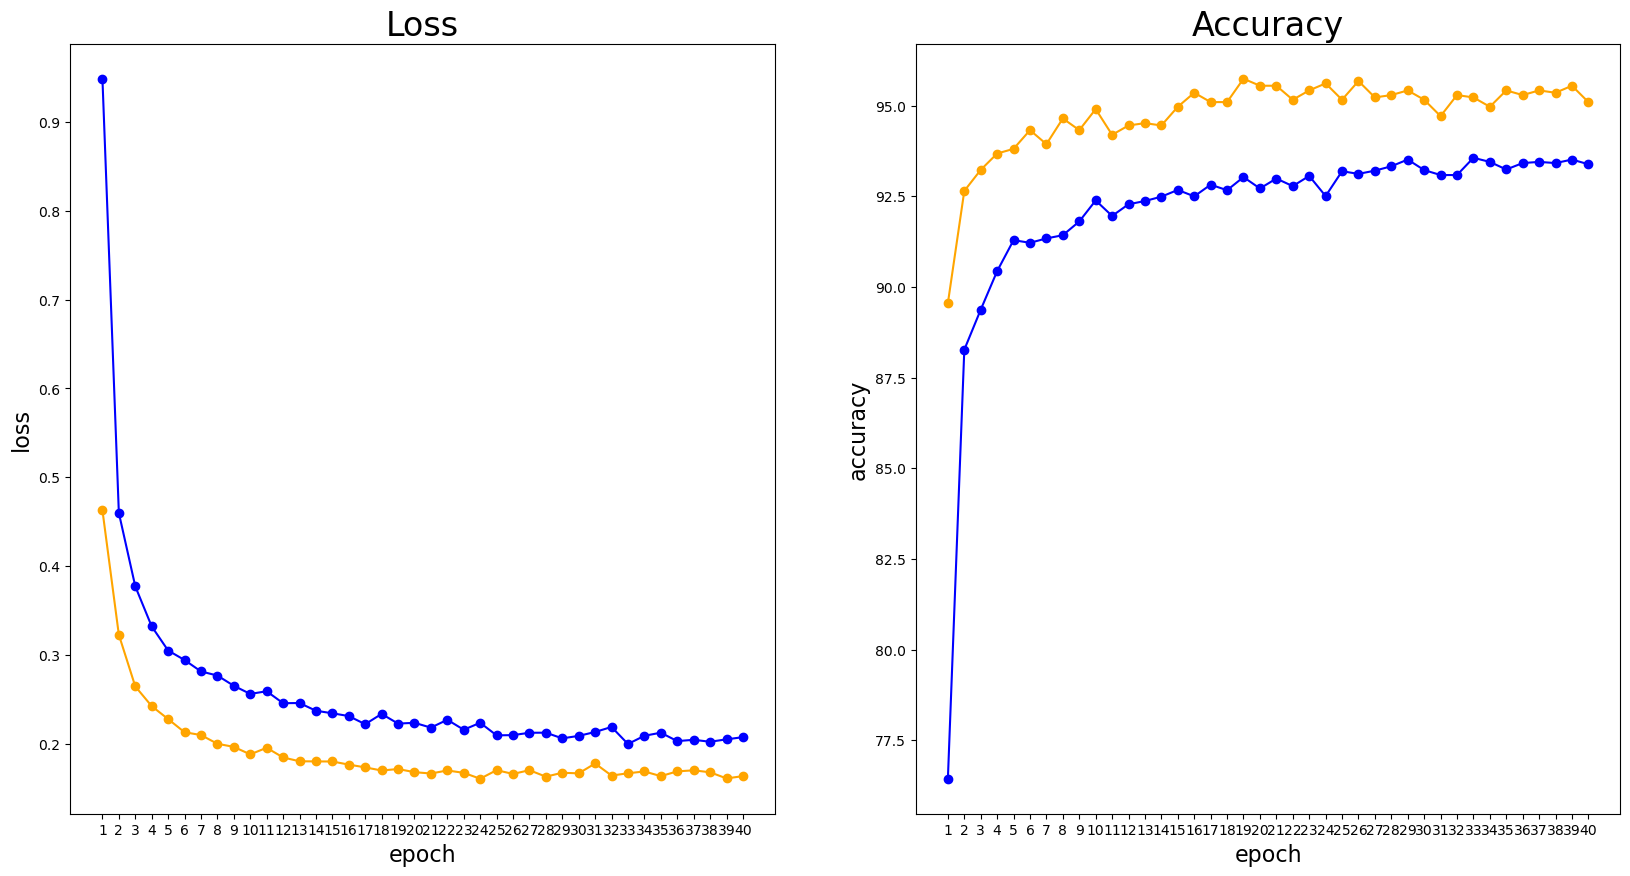

In [ ]:
fig = plt.figure(figsize = (20, 10))

loss_ax = fig.add_subplot(1, 2, 1)
loss_ax.set_title('Loss', size=24)
loss_ax.set_xlabel('epoch', size=16)
loss_ax.set_xticks([i for i in range(epochs)], labels=[i+1 for i in range(epochs)])
loss_ax.set_ylabel('loss', size=16)
loss_ax.plot(train_losses, color='blue', marker='o', label='Train')
loss_ax.plot(dev_losses, color='orange', marker='o', label='Dev')

accuracy_ax = fig.add_subplot(1, 2, 2)
accuracy_ax.set_title('Accuracy', size=24)
accuracy_ax.set_xlabel('epoch', size=16)
accuracy_ax.set_xticks([i for i in range(epochs)], labels=[i+1 for i in range(epochs)])
accuracy_ax.set_ylabel('accuracy', size=16)
accuracy_ax.plot(train_accuracies, color='blue', marker='o', label='Train')
accuracy_ax.plot(dev_accuracies, color='orange', marker='o', label='Dev')

fig.show()

# Test With Custom Picture

In [ ]:
def predict_image(image, model):
    image = Image.open(image)
    transform = data_transforms['original']
    
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    
    pred = model(image)
    pred = idx_to_class[int(pred.argmax(1))]
    return pred

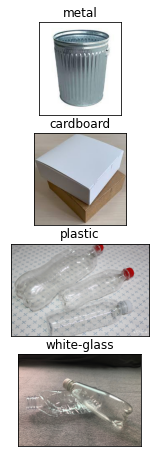

In [ ]:
model = CustomModel(num_classes, 0.3)
model.load_state_dict(torch.load(os.path.join(MODEL_PATH)))

model.eval()

plt.figure(figsize=(10,20))

test_path = '/content/gdrive/MyDrive/test_images'
imgs = [os.path.join(test_path, file_name) for file_name in os.listdir(test_path)] # TODO: write your image path here
with torch.no_grad():
    for idx, img in enumerate(imgs):
        plt.subplot(10, 1, idx + 1)
        pred = predict_image(img, model)
        plt.title(pred)
        plt.xticks([]) 
        plt.yticks([])
        plt.imshow(Image.open(img))  

